In [2]:
import tensorflow as tf

In [3]:
from data.dataloader import tf_data_generator
from models.losses import tf_loss_function_mat

In [4]:
from models.gru_denoiser import BiGRUSpectralDenoiserTensorFlow

In [5]:
from training.trainer import Trainer_tf

In [6]:
from estimator.QIS import tf_QIS_batched

In [7]:
import numpy as np
import matplotlib.pyplot as plt

## NN

In [21]:
def mse(A, B):
    A = tf.cast(A, tf.float32)
    B = tf.cast(B, tf.float32)
    return tf.reduce_mean(tf.square(A - B))

In [9]:
N_min = 70
N_max = 250
T_min = 30
T_max = 70
batch_size=100

### Training loop — Generated Data

In [10]:
model_generated_data = BiGRUSpectralDenoiserTensorFlow(hidden_size=96) # hidden_size to be tunned 
# lr, weight_decay, batch_size, epochs, hidden_size to be tunned

In [11]:
trainer = Trainer_tf(
    model=model_generated_data, is_train_on_real_data = False, loss_function=tf_loss_function_mat, data_generator=tf_data_generator, lr = 1e-4, weight_decay=1e-5,
    batch_size=batch_size, epochs=50, N_min=N_min, N_max=N_max, T_min=T_min, T_max=T_max, log_interval=10, accumulate_steps=2, dataset=None, missing_constant = 2,
)
# need to epochs to be big when there is lot of choise for N and T 
# need for big batch_size when df is big
losses = trainer.train()

Starting training for 50 epochs…
Epoch 10/50 — loss: 0.00621992
Epoch 20/50 — loss: 0.01289966
Epoch 30/50 — loss: 0.02125278
Epoch 40/50 — loss: 0.00605276
Epoch 50/50 — loss: 0.00818218
Training complete.


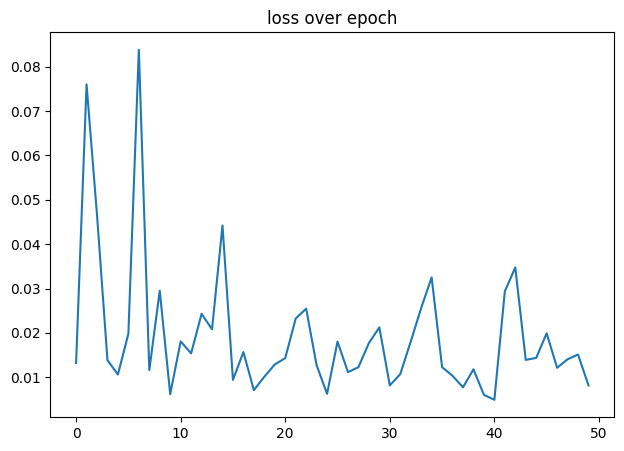

In [12]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(losses)
plt.title("loss over epoch")
plt.savefig("images/training_loss.png")
plt.show()

### Comparaison (oos)

In [13]:
batch_size_oos = 500

In [14]:
input_seq_cov_miss, Q_emp_miss, Sigma_true_miss, T, Sigma_hat_diag_miss, R_miss          = next(tf_data_generator(batch_size_oos, missing_constant = 2, N_min=60, N_max=60, T_min=30, T_max=30))
input_seq_cov_no_miss, Q_emp_no_miss, Sigma_true_no_miss, T, Sigma_hat_diag_no_miss, R_no_miss = next(tf_data_generator(batch_size_oos, missing_constant = 1, N_min=60, N_max=60, T_min=30, T_max=30))

In [15]:
lam_emp_miss     = input_seq_cov_miss[:,:,0]
lam_pred_miss    = model_generated_data(input_seq_cov_miss) # ,lam_emp_miss
lam_emp_no_miss  = input_seq_cov_no_miss[:,:,0]
lam_pred_no_miss = model_generated_data(input_seq_cov_no_miss) # ,lam_emp_no_miss

In [16]:
lam_emp_miss[0]

<tf.Tensor: shape=(60,), dtype=float32, numpy=
array([ 6.6191716 ,  6.135777  ,  5.2207036 ,  4.941229  ,  4.3775625 ,
        4.169776  ,  3.9277651 ,  3.72024   ,  3.156581  ,  2.831095  ,
        2.6537316 ,  2.6145132 ,  2.0595617 ,  1.9142565 ,  1.5861404 ,
        1.412745  ,  1.2988559 ,  1.0775323 ,  0.9904379 ,  0.82486427,
        0.791878  ,  0.5957429 ,  0.4810558 ,  0.40902072,  0.37126708,
        0.3035084 ,  0.11397368,  0.0516099 , -0.01708069, -0.01827128,
       -0.02473277, -0.02657527, -0.02756325, -0.03001528, -0.03622086,
       -0.03740542, -0.04203221, -0.0470229 , -0.05262297, -0.05793603,
       -0.0634849 , -0.07193195, -0.08187789, -0.08901104, -0.09128402,
       -0.10518012, -0.10848743, -0.1334806 , -0.14281844, -0.15338291,
       -0.18826339, -0.20712213, -0.21813284, -0.23636976, -0.29562768,
       -0.33183235, -0.34785667, -0.41785425, -0.45877856, -0.49041376],
      dtype=float32)>

In [17]:
lam_pred_miss[0]

<tf.Tensor: shape=(60,), dtype=float32, numpy=
array([0.57626617, 0.6509755 , 0.6410852 , 0.64853567, 0.67774785,
       0.675534  , 0.6788158 , 0.6324529 , 0.66145074, 0.66554844,
       0.616624  , 0.6340625 , 0.659338  , 0.6296507 , 0.6323565 ,
       0.6182967 , 0.6357727 , 0.6455799 , 0.6419309 , 0.5964622 ,
       0.60312307, 0.6027559 , 0.6229651 , 0.6691235 , 0.6417864 ,
       0.6568969 , 0.64002424, 0.6999859 , 0.49472916, 0.65663666,
       0.61496174, 0.5025227 , 0.5781998 , 0.64839286, 0.5923725 ,
       0.6182409 , 0.6269915 , 0.65798205, 0.5657886 , 0.6026431 ,
       0.56333244, 0.5696761 , 0.59085715, 0.5949053 , 0.6223483 ,
       0.61149603, 0.58497614, 0.6304682 , 0.5985364 , 0.59383035,
       0.5901695 , 0.6241364 , 0.64221585, 0.70064217, 0.6828618 ,
       0.6936386 , 0.74274904, 0.75166935, 0.7933433 , 0.8915317 ],
      dtype=float32)>

Comparaison matrix $Corr$

In [18]:
# Corr from predicted eigenvalues
Corr_pred_miss = tf.matmul(
    tf.matmul(Q_emp_miss, tf.linalg.diag(lam_pred_miss)),
    Q_emp_miss,
    transpose_b=True
)

Corr_pred_no_miss = tf.matmul(
    tf.matmul(Q_emp_no_miss, tf.linalg.diag(lam_pred_no_miss)),
    Q_emp_no_miss,
    transpose_b=True
)

# Corr from empirical eigenvalues
Corr_emp_miss = tf.matmul(
    tf.matmul(Q_emp_miss, tf.linalg.diag(lam_emp_miss)),
    Q_emp_miss,
    transpose_b=True
)

Corr_emp_no_miss = tf.matmul(
    tf.matmul(Q_emp_no_miss, tf.linalg.diag(lam_emp_no_miss)),
    Q_emp_no_miss,
    transpose_b=True
)

In [19]:
# MISS
diag_oos_miss = tf.linalg.diag_part(Sigma_true_miss)
std_oos_miss = tf.sqrt(tf.maximum(diag_oos_miss, 1e-12))
Corr_true_miss = Sigma_true_miss / (
    std_oos_miss[:, None, :] * std_oos_miss[:, :, None] + 1e-12
)

# NO MISS
diag_oos_no_miss = tf.linalg.diag_part(Sigma_true_no_miss)
std_oos_no_miss = tf.sqrt(tf.maximum(diag_oos_no_miss, 1e-12))
Corr_true_no_miss = Sigma_true_no_miss / (
    std_oos_no_miss[:, None, :] * std_oos_no_miss[:, :, None] + 1e-12
)

In [22]:
fro_Corr_pred_miss    = mse(Corr_pred_miss, Corr_true_miss)
fro_Corr_pred_no_miss = mse(Corr_pred_no_miss, Corr_true_no_miss)
fro_Corr_emp_miss     = mse(Corr_emp_miss, Corr_true_miss)
fro_Corr_emp_no_miss  = mse(Corr_emp_no_miss, Corr_true_no_miss)

In [23]:
print(f"MSE Corr after miss + NN:         {fro_Corr_pred_miss.numpy():.6f}")
print(f"MSE Corr after no miss + NN :     {fro_Corr_pred_no_miss.numpy():.6f}")
print(f"MSE Corr after miss + no NN :     {fro_Corr_emp_miss.numpy():.6f}")
print(f"MSE Corr after no miss  + no NN : {fro_Corr_emp_no_miss.numpy():.6f}")

MSE Corr after miss + NN:         0.002790
MSE Corr after no miss + NN :     0.000635
MSE Corr after miss + no NN :     0.053835
MSE Corr after no miss  + no NN : 0.033957


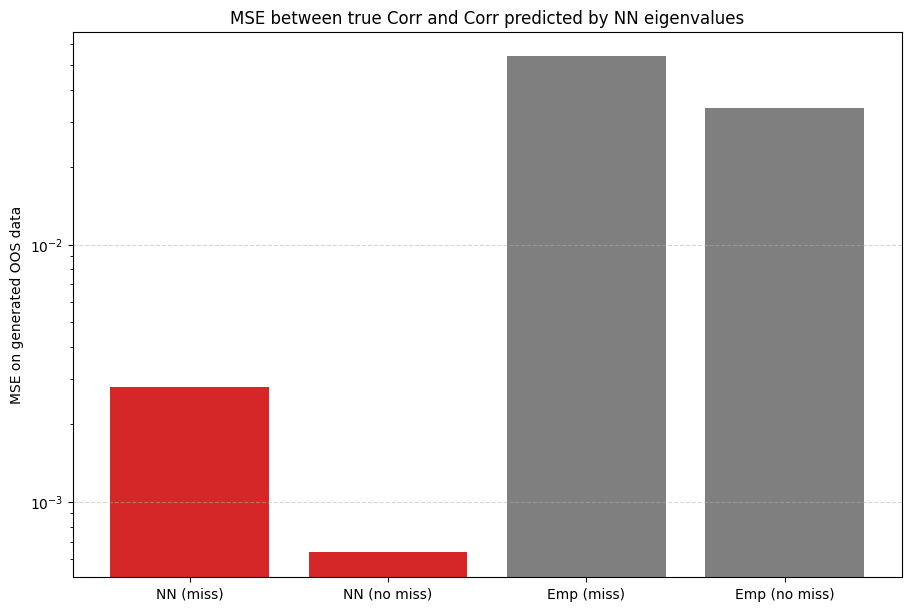

In [24]:
labels = ['NN (miss)', 'NN (no miss)', 'Emp (miss)', 'Emp (no miss)']
values = [
    fro_Corr_pred_miss.numpy(),
    fro_Corr_pred_no_miss.numpy(),
    fro_Corr_emp_miss.numpy(),
    fro_Corr_emp_no_miss.numpy(),
]

colors = ['tab:red','tab:red','tab:gray','tab:gray']

plt.figure(figsize=(9,6), constrained_layout=True)
plt.bar(labels, values, color=colors)
plt.yscale('log')
plt.ylabel('MSE on generated OOS data')
plt.title("MSE between true Corr and Corr predicted by NN eigenvalues")
plt.grid(axis='y', ls='--', alpha=.5)
plt.show()

In [25]:
D_miss = tf.cast(tf.sqrt(tf.linalg.diag(Sigma_hat_diag_miss)), tf.float32)
D_no_miss = tf.cast(tf.sqrt(tf.linalg.diag(Sigma_hat_diag_no_miss)), tf.float32)

Corr_pred_miss = tf.cast(Corr_pred_miss, tf.float32)
Corr_pred_no_miss = tf.cast(Corr_pred_no_miss, tf.float32)
Corr_emp_miss = tf.cast(Corr_emp_miss, tf.float32)
Corr_emp_no_miss = tf.cast(Corr_emp_no_miss, tf.float32)

Sigma_pred_miss = tf.matmul(tf.matmul(D_miss, Corr_pred_miss), D_miss)
Sigma_pred_no_miss = tf.matmul(tf.matmul(D_no_miss, Corr_pred_no_miss), D_no_miss)
Sigma_emp_miss = tf.matmul(tf.matmul(D_miss, Corr_emp_miss), D_miss)
Sigma_emp_no_miss = tf.matmul(tf.matmul(D_no_miss, Corr_emp_no_miss), D_no_miss)


In [26]:
Sigma_QIS = tf_QIS_batched(R_no_miss)

lam_QIS, _ = tf.linalg.eigh(Sigma_QIS)
eigv, _ = tf.linalg.eigh(Sigma_true_no_miss)

In [27]:
fro_Sigma_pred_miss    = mse(Sigma_pred_miss, Sigma_true_miss)
fro_Sigma_pred_no_miss = mse(Sigma_pred_no_miss, Sigma_true_no_miss)
fro_Sigma_emp_miss     = mse(Sigma_emp_miss, Sigma_true_miss)
fro_Sigma_emp_no_miss  = mse(Sigma_emp_no_miss, Sigma_true_no_miss)
fro_Sigma_QIS          = mse(Sigma_QIS, Sigma_true_no_miss)

In [28]:
print(f"MSE Sigma after miss + NN:         {fro_Sigma_pred_miss.numpy():.6f}")
print(f"MSE Sigma after no miss + NN :     {fro_Sigma_pred_no_miss.numpy():.6f}")
print(f"MSE Sigma after miss + no NN :     {fro_Sigma_emp_miss.numpy():.6f}")
print(f"MSE Sigma after no miss  + no NN : {fro_Sigma_emp_no_miss.numpy():.6f}")
print(f"MSE Sigma QIS :                    {fro_Sigma_QIS.numpy():.6f}")

MSE Sigma after miss + NN:         0.003441
MSE Sigma after no miss + NN :     0.001662
MSE Sigma after miss + no NN :     0.055455
MSE Sigma after no miss  + no NN : 0.035240
MSE Sigma QIS :                    0.001216


/var/folders/l1/kv6fjcx118x75w1kjzdxphsm0000gp/T/ipykernel_87569/132896052.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


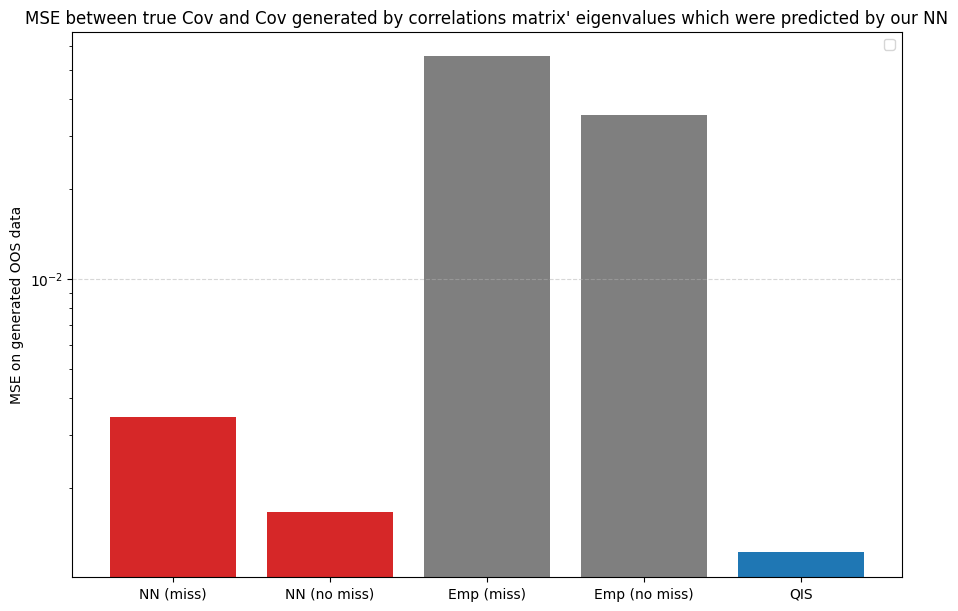

In [30]:
labels = ['NN (miss)', 'NN (no miss)', 'Emp (miss)', 'Emp (no miss)', 'QIS']# 'projected Em (miss)' 'projected Em (no miss)']
values = [fro_Sigma_pred_miss.numpy(), fro_Sigma_pred_no_miss.numpy(), fro_Sigma_emp_miss.numpy(), fro_Sigma_emp_no_miss.numpy(), fro_Sigma_QIS.numpy()]# fro_Sigma_near_miss.item(), fro_Sigma_near_no_miss.item()]
colors = ['tab:red','tab:red','tab:gray','tab:gray', 'tab:blue']#,, 'tab:gray''tab:gray']

plt.figure(figsize=(9,6), constrained_layout=True)
plt.bar(labels, values, color=colors)
plt.yscale('log')
plt.ylabel('MSE on generated OOS data')
plt.title("MSE between true Cov and Cov generated by correlations matrix' eigenvalues which were predicted by our NN")
plt.grid(axis='y', ls='--', alpha=.5)
plt.legend()
plt.show()
